# Optimization 

The goal of this notebook is just to dip your toes into the realm of optimization which is arguably the most important research topic today - all of ML relies on being able to optimize functions ASAP.

In [2]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from matplotlib.animation import FuncAnimation

from IPython.core.display import Image, display
from mpl_toolkits.mplot3d import Axes3D

# Exposition

Optimization is very easy to intuitively see what the goal is. We have a task like we want to feed the poor. This is either yes or no - alongside this objective, we desire to minimize the costs so as to be able to feed everyone which forms a constraint in our system. Alongside this cost constraint, we could impose a nutritional constraint where we would like to maximize the nutritional value as well. These contrast with each other in that as one becomes more and more satisfied, the other becomes less satisfied (lower cost = lower nutritional value generally) and so optimization creates a difficult, but easy to understand objective where we desire to find the best solution or food layout given and admissible set of choices to begin with.

## The Setup of Optimization Tasks

The problem we are interested in is nonlinear optimization and our problem can be more formally stated as follows: let $x$ be an $n$-dimensional real vector: 

$$x=\left(x^{(1)},\dots,x^{(n)}\right)^T\in\mathbb{R}^n,$$

and $f_0(\cdot),\dots,f_m(\cdot)$ be some real-valued functions defined on a set $Q\subset \mathbb{R^n}$. Nesterov's book focuses on problems of the minimization problem

$$\min\limits_{x\in Q} f_0(x)$$

such that 

$$f_j(x)\& 0,\;\;\; j=1,\dots,m,$$

where $\&$ could be $\leq, \geq,$ or $=$. Here we denote $f_0(\cdot )$ as the **objective function** and 

$$f(x)=\left(f_1(x),\dots,f_m(x)\right)^T$$

is called the vector of **functional constraints**, the set $Q$ is called the **basic feasible set**, and we call the **entire feasible set** as 

$$\mathcal{F} = \left\{x\in Q: f_j(x)\leq 0,j=1,\dots,m\right\}$$

which basically denotes the points satisfying the constraints of those tested from the basic feasible set. We take the minimization of $f_0(\cdot)$ above but as equally valid, we could have taken $-f(\cdot)$ if we desired a maximization of $f(\cdot)$. 

Optimization algorithms and techniques are generally well-defined and intended for an entire class of problems - not function by function of course. Understanding the class that a particular problem belongs to is the most important step in being able to solve it or cannot. With that in mind, we have a nice classification of optimization problem types based on the functions involved:

- **Constrained problems** where $\mathcal{F}$ is a proper subset of $\mathbb{R}^n$

- **Unconstrained problems** where $\mathcal{F}$ spans all of $\mathbb{R}^n$

- **Smooth problems** where the objective function and functional constraints are all smooth (continuous derivatives)

- **Nonsmooth problems** where some or all of the functions above are non-differentiable

- **Linearly constrained problems** where the functional constraints are affine (a linear function coupled with a translation - not centered at the origin):

$$f_j(x) = \sum\limits_{i=1}^n a_j^{(i)}x^{(i)} + b_j.$$

- **Linear optimization problems** where the objective function is affine.

- **Quadratic optimization problems** where the objective function is quadratic.

- This list goes on, but these are the important ones.

Similarly, we can disect and classify problems based on the feasible set:

- The minimization problem is **feasible** (not impossible) if $\mathcal{F}\neq 0$

- The minimization problem is **strictly feasible** if there exists an $x\in Q$ such that $f_j(x)<0$ (or $f_j(x)>0$) for all inequality constrains and $f_j(x)=0$ for all equality constraints. Basically same as above, but strict inequalities only.

Finally, we also have different classes of problems for different types of solutions:

- $x^*\in\mathcal{F}$ is called a **global optimal solution** to the minimization problem if $f_0(x^*)\leq f_0(x)$ for all $x\in\mathcal{F}$. In this case, $f_0(x^*)$ is called the global optimial value of the problem.

- $x^*\in\mathcal{F}$ is called a **local solution** to the minimization problem if there exists a set $\hat{\mathcal{F}}\subset \mathcal{F}$ such that $x^*\in\hat{\mathcal{F}^\circ}$ (the interior of $\hat{\mathcal{F}}$) and $f_0(x^*)\leq f_0(x)$ for all $x\in\hat{\mathcal{F}}$ (local minimum). If $f_0(x^*)<f_0(x)$ for all $x\in\hat{\mathcal{F}}\setminus \{x^*\}$, then $x^*$ represents a strict (or isolated) local minimum.

## The Performance of Optimization Algorithms

We have a **problem $P$** inside a more broad class of problems $\mathcal{P}$ (i.e. smooth functions, second-order derivatives are continuous, etc.) and we desire to find the best **optimization method $\mathcal{M}$**. Generally our method does not have complete information about a problem (i.e. it's missing some values of the function and/or it's derivatives) and so we label the known part of the problem $P$ the **model $\Sigma$**. To solve a problem, there must be an **oracle $\mathcal{O}$** (or genie of sorts as pictured below) that answers our calls or questions. For instance, a call to the oracle could be "genie what's the value of the derivative of the objective of $P$ at $x\in\mathcal{F}$". In other words, I generally think of the oracle as simply giving us an evaluation of the function.

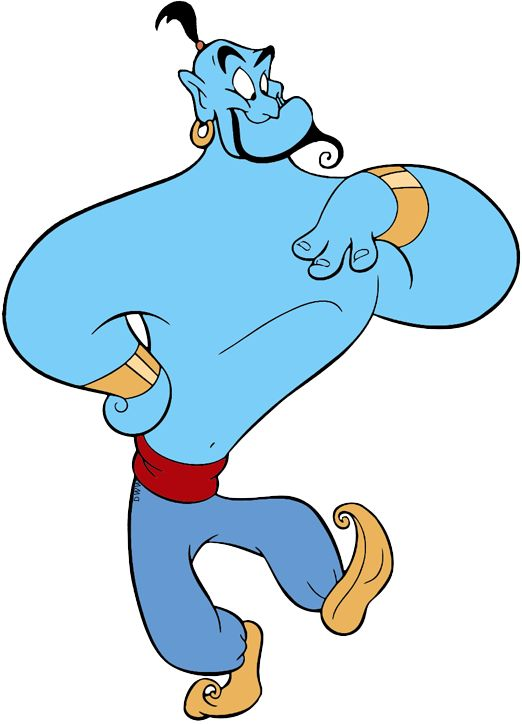

In [6]:
display(Image("figs/aladdin.jpg", width=300, unconfined=True))

There could also be different types of oracles. One example could be a oracle that gives us a very fine approximation of the values of a function (say within $\epsilon$ of the true value) while another could be a stochastic oracle that randomly gives us values that could have noise (think dynamical systems where we employ Kalman filters). Now if we want to evaluate a method $\mathcal{M}$ given a particular oracle $\mathcal{O}$ and model $\Sigma$, we naturally would view the *performance as the method's performance on the worst problem $P_W$* for the given model and oracle. As we have a plan for evaluating a method (or really optimization algorithm), we want to understand what exactly is the performance of a method on a single problem $P_W$. Nesterov defines it as follows:

The **performance of $\mathcal{M}$ on $P_W$** is the total amount of computational effort required by method $\mathcal{M}$ to solve the problem $P$. 

To couple this definition of what is meant by the performance, we define **solving the problem** as meaning finding an approximate solution to $\mathcal{P}$ with some degree of accuracy $\epsilon > 0$. We will denote $\tau_\epsilon$ as the stopping criteria - this for instance could be $\tau_\epsilon = f(x_k) - f(x_{k-1})<\epsilon$. Similarly, we must define what is meant by computational effort. This can be seen as either **analytical complexity** which is the number of calls made to the oracle to solve a problem $P$ with accuracy $\epsilon$ and **arithmetical complexity** which denotes the total number of arithmetic operations necessary for solving a problem $P$ with degree of accuracy $\epsilon$. Notice that arithmetical complexity is representative of the entire running time, but generally analytical complexity is easier to compute and arithmetical complexity is a function of analytical complexity. Anyhow, to solve a problem $P\in\mathcal{P}$ with a tuple of characteristics $\mathcal{P}=(\Sigma, \mathcal{O}, \tau_{\epsilon})$, we employ the following **general iterative scheme**:

**Input**: Starting point $x_0$ and accuracy $\epsilon >0$.

**Initialization**: Set $k=0, \mathcal{J}_{-1}=\emptyset$. Here $k$ represents the **iteration counter** and $\mathcal{J}_k$ is the accumulated **informational set** (what we got from the oracle and our updates).

**Main Loop**:

**1.** Call oracle $\mathcal{O}$ at point $x_k$.

**2.** Update the informational set: $\mathcal{J}_k=\mathcal{J}_{k-1}\bigcup (x_k,\mathcal{O}(x_k))$.

**3.** Apply the rules of method $\mathcal{M}$ to $\mathcal{J}_k$ and generate a new point $x_{k+1}$.

**4.** Check criterion $\tau_\epsilon$. If yes, then form an output $\bar{x}$. Otherwise set $k=k+1$ and go to step one.

In order for us to obtain analytical complexity bounds, we must make a standard assumption which is called the **local black box concept**:

**1.** The only information available for the numerical scheme is the answer of the oracle.

**2.** The oracle is *local*: A small variation of the problem far enough from the test point $x$, which is compatible with the description of the problem class, does not change the answer $x$.

Now why do we make these assumptions is probably the most natural question after hearing this? For 1., problems of interest today are very complicated dynamical systems like neural networks and more complicated compositions of functions and the oracle is our only sourrce of information - we do not know how to inherently compute some of the values without it or the problem would be trivially solved without needing optimization. An example of a problem not satisfying this constraint would be the minimum of $y=x^2$ - there's no need for optimization here when basic calculus works like a charm. As for the latter assumption, I have no idea what constitutes a small variation of the problem but within the problem class means - I am guessing that this means that the calls are consistent for problems within the class which would imply that we can guarantee analytical bounds for all of the class but that seems dumb/obvious. 

Finally, for minimization problems phrased in this manner, we generally call it a **functional model** where assumptions are related to the smoothness of the functions in the problem. Thus, we have different types of oracles to clarify the problem type:

- **Zero-order oracle**: returns the function value $f(x)$

- **First-order oracle**: returns the function value $f(x)$ and the gradient $\nabla f(x)$

- **Second-order oracle**: returns $f(x)$, the gradient $\nabla f(x)$, and the Hessian $\nabla^2 f(x)$.

# Gradient Descent



# Mirror Descent

Suppose that the gradient is not Lipschitz. Then what gives - can we not still use the theoretical update rule from gradient descent with Lipschitz constant

$$x^{t+1}\leftarrow \arg\min\left\{f(x^t + \langle \nabla f(x^t), x - x^t\rangle)\right\}$$

or even the constant step rule

$$x^{t+1}\leftarrow x^t - \eta \nabla f(x^t)?$$

To answer the question where we use the theoretical update, consider the function $f(x)=x^2$ defined in the convex set $[-1,1]$. Then notice that our update equation is 

$$x^{t+1}\leftarrow \arg\min\left\{x^t + 2x^t(x-x^t)\right\}.$$

Initializing $x^0=1$ yields that $x^1\leftarrow \arg\min\left\{2x-1\right\}$ so $x^1=-1$ as pictured below with the blue lines that are the linear approximations of our functions. Then $x^2\leftarrow \arg\min\left\{-2x-3\right\}=1$. We see that this repeats! We're stuck in an infinite loop because the step size is too big.

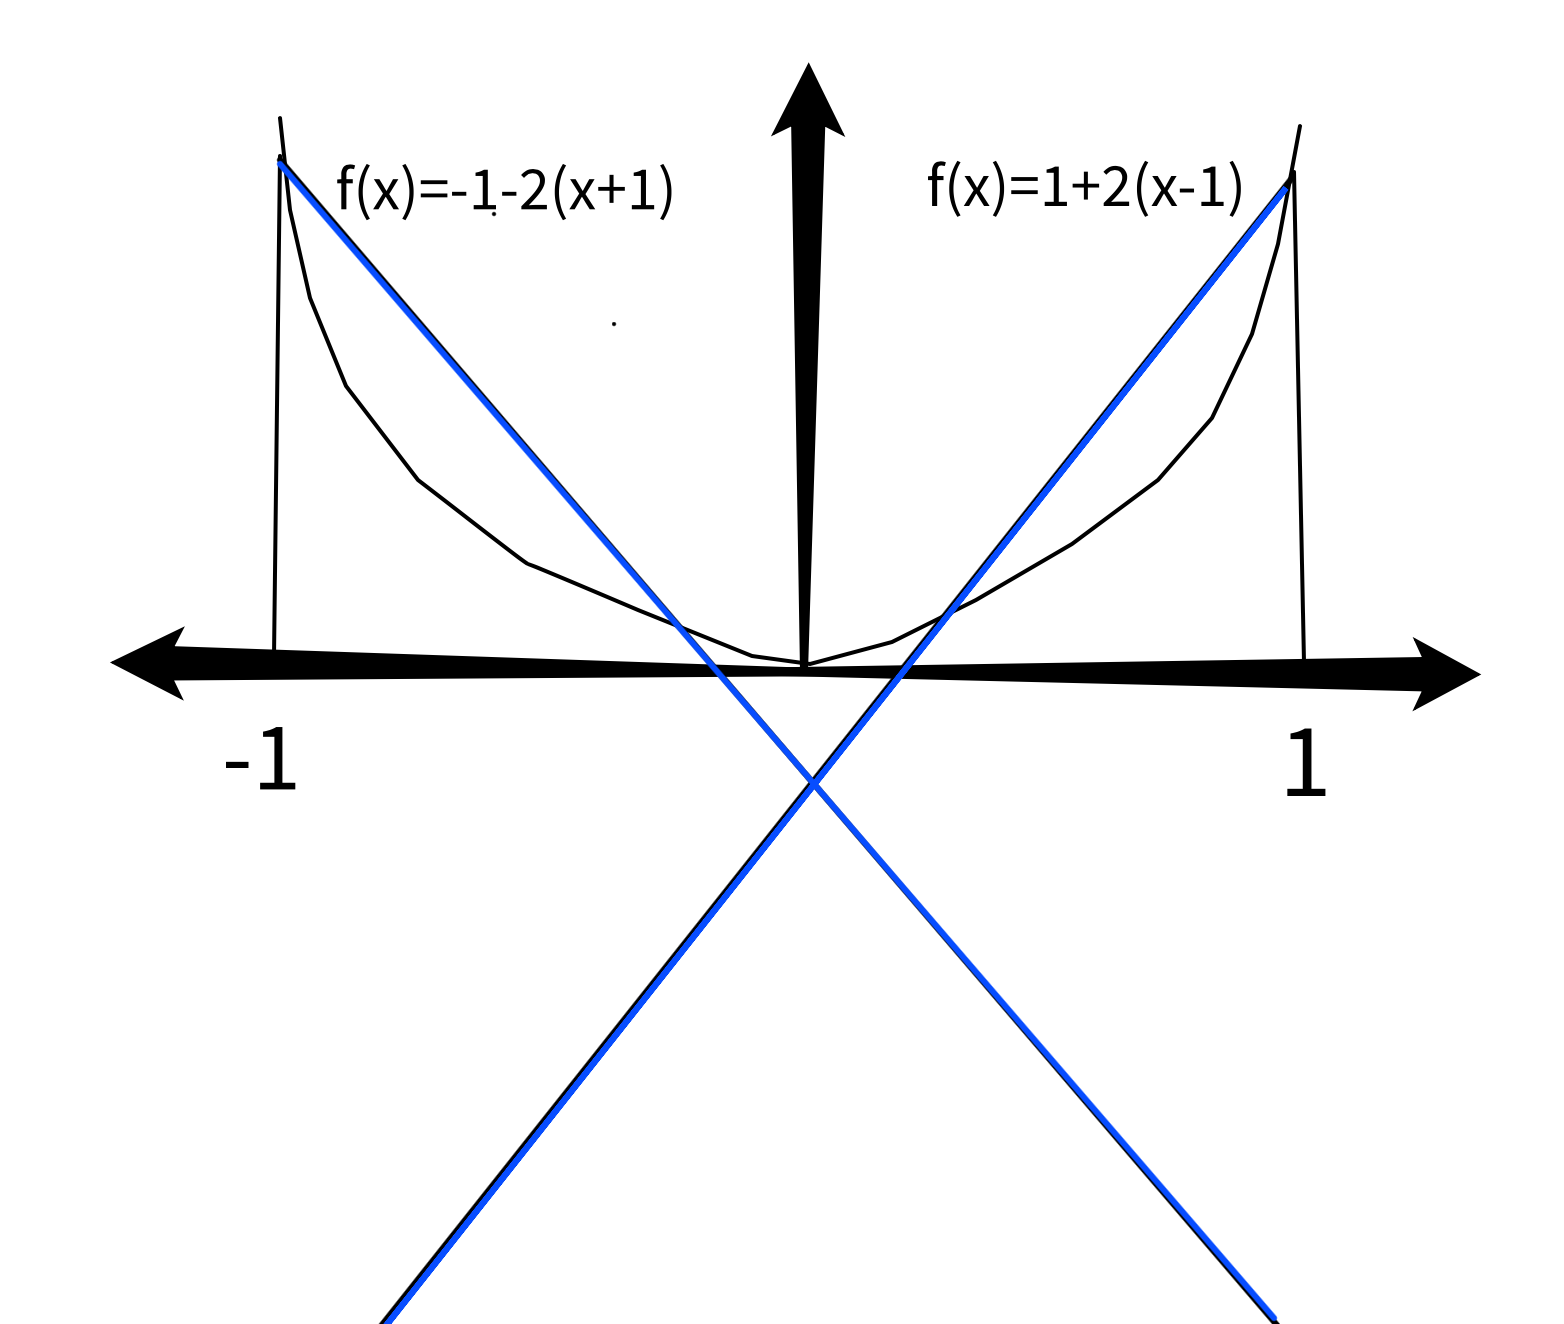

In [7]:
# our objective function with the steps we take
display(Image("figs/quadratic.png", width=300, unconfined=True))

Alright well there's a reason we label that update theoretical garbage. But what about a constant step size of say $\eta=1$. If this is the case, then we notice that our update is given by $x^{t+1}\leftarrow x^t+2x^t$. This again gets stuck in between updating values as either $-1$ or $1$. Okay, well this is where we would like to instead rely on quadratic lower bounds in the case of strongly convex functions. Or you may simply just drop the step size to ensure convergence or if you're clever, you may hypothesize that if we keep bouncing between the values on the boundary then we could just take the average of the most recent $n$ or so steps which would yield $0$ in the case of an even number of steps. The latter two while they may remedy some cases, do not help in general. Let's talk a bit more about how we could improve this in the case of strongly convex functions. 

Returning to the example graphic above, we see that $f(x)=x^2$ is strongly convex. Thus, we can instead suggest a quadratic lower bound for the update. Consider the case where we say that $\sigma\leq 2$, then we have that $f(x)\geq f(y)+\langle \nabla f(y),x-y\rangle +\frac{\sigma}{2}\langle x-y,x-y\rangle$ trivially. With this in mind, we differentiate the update rule to solve for the argmin as asked for. Doing so with respect to $x$ yields 

$$x^{t+1}\leftarrow x^t - \frac{1}{\sigma} 2x^t.$$

Notice that while $2$ is the largest choice of $\sigma$ that ensures the function is strongly convex. We can instead increase $\sigma$ if we desire $x^{t+1}$ to be nearby $x^t$ (and prevent the scenario above). This basically changes the function we were originally updating with and instead replaces it with a function that is more flexible and easier to find extrema. **To summarize:** even without a continuous gradient, we can make a function $f_t$ smoother by considering a distance function $D:K\times K\rightarrow \mathbb{R}$ that lassos in the point $x^{t+1}$ to be close enough to the starting point. We can think of this as ensuring slow and steady progress by exploring more of the space and preventing our iterates from bouncing along the boundary. The distance function that does this is known as the regularizer - and this process of smoothing the objective function to ease our task is known as **regularization**. 

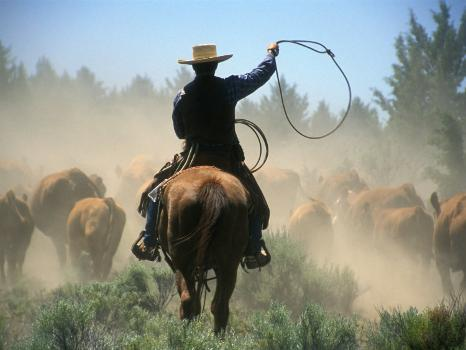

In [8]:
display(Image("figs/lasso.jpg", width=300, unconfined=True))

# Newton's Method

Here I would like to introduce Newton's method as it resonates very much with the concepts in gradient descent. Consider again the problem of finding a minimum of $f(x)$ for $x\in\mathbb{R}^n$ where $f$ is twice-continuously differentiable with Lipschitz Hessian and Gradient (constant $M$). Newton's method is a technique for finding a root of a function.

That is, consider $g:\mathbb{R}\rightarrow \mathbb{R}$. Newton proposed that if we want to find the $x^*$ such that $g(x^*)=0$, then under certain conditions, we have that the linear approximation (or first order Taylor expansion) does a good job 

$$g(x^*)= g(x+(x^*-x))\approx g(x)+g'(x)\Delta x =0\iff \Delta x=-\frac{g(x)}{g'(x)}.$$

His iterative scheme can be explained algorithmically as $x_{t+1}=x_t-\frac{g(x)}{g'(x)}$. In other words, $g(\cdot)$ can be some ugly nonlinear system and Newton says to simply linearly approximate this function in some neighborhood close enough to the minimum and then step very quickly to traverse down the line. Of course, these conditions are strong, but the idea remains very powerful in optimization - approximation by simpler functions - he did this in the 1700s! 

We can extend this logic to functions over $\mathbb{R}^n$ and apply it to our minimization problem as we are interested in $\nabla f(x)=0$ as this is where local extrema lie provided the Hessian is non-degenerate. Instead our iteration scheme would be given by

$$x_{t+1}=x_t-\nabla^2 f(x_t)^{-1}\nabla f(x_t).$$

Newton's method is much faster than Gradient descent for problems with invertible Hessians and strict local minimums. However I'm not a sleazy car salesman - this method fails miserably for non-invertible (singular) Hessians and the greedy step size can run us away into the sunset and diverge. As a concrete example, take the following from Nesterov's "Lectures on Convex Optimization": 

$$f(x)=\frac{x}{\sqrt{1+x^2}}.$$

Let us plot the function.

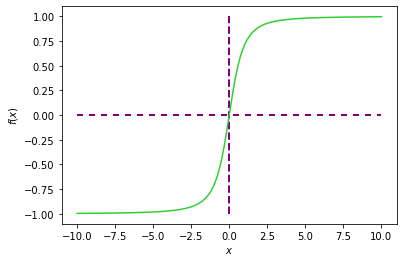

In [4]:
def rational_func(x):
    return x / np.sqrt(1 + x ** 2)

x = np.linspace(-10, 10, 1000)
plt.plot(x, rational_func(x), color='limegreen')
plt.plot(x, np.zeros(1000), color='purple', ls='--', dashes=(3, 3), lw=2)
plt.vlines(x=0, ymin=-1, ymax=1, color='purple', ls='--', lw=2)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.show()

Clearly the minimum is at zero. However Newton's iterative scheme is given by 

$$x_{t+1}=x_t-\frac{x_t}{\sqrt{1+x_t^2}}\cdot (1+x_t^2)^{3/2}=-x_t^3.$$

If $|x_0|<1$, then this converges cubically. However if $x_0$ is not in the region, this diverges very quickly. Akin to the support provided by the step size in gradient descent where we lasso in the gradient to prevent overstepping the extrema, there is a method in practice known as damped Newton's method:

$$x_{t+1}=x_t - h_t\nabla^2 f(x_t)^{-1}\nabla f(x_t)$$

where $h_t$ can be approximated by the same step functions for GD. Gradient descent converges linearly while Newton's method converges quadratically (provided a non-degenerate Hessian which is not imposed in GD). 

Interestingly enough, we can combine these methods!! As GD is converges linearly (pretty slow, but steady), we can use GD to get within a neighborhood of the local minima and then apply Newton's method to finish the job. 


# Definitions

Apologies in advance as algorithms cannot be written in nice pseudo-code in native Jupyter, so I have some jank bulleted lists

### Differentiability

For a function $f:\mathbb{R}\rightarrow\mathbb{R}$ and $x\in\mathbb{R}$, we say that $f$ is differentiable at the point $x$ if 

$$\lim\limits_{\delta \rightarrow 0} \frac{f(x+\delta)-f(x)}{\delta}$$

exists. We say that a function is continuously differentiable if the derivative is also continuous.

### Partial Derivatives

For a function $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$, let $\{e_1,\dots,e_n\}$ and $\{d_1,\dots,d_m\}$ denote the standard bases for $\mathbb{R}^n$ and $\mathbb{R}^m$ respectively. Then for $x\in\mathbb{R}^n$, we can decompose $f$ into it's $m$ components:

$$f(x)=\sum\limits_{i=1}^m f_i(x)d_i.$$

From here, we define the partial derivative of $g$ at $x$ as 

$$\frac{\partial f_i}{\partial x_j}(x)=D_jf_i(x)=\lim\limits_{t\rightarrow 0} \frac{f_i(x+te_j)-f_i(x)}{t}$$

provided this limit exists.

### Directional Derivatives

The rate of change (or directional derivative) of a real-valued function $f$ with respect to a unit vector $v\in\mathbb{R}^n$ at a point $x=(x_1,\dots,x_n)^T\in\mathbb{R}^n$ is given by 

$$D_{v}f(x)=\lim\limits_{t\rightarrow 0} \frac{f(x_1+tv_1,\dots,x_n+tv_n)-f(x_1,\dots,x_n)}{t}=\nabla f(x)\cdot v$$

where $\nabla f(x)=\begin{bmatrix}\frac{\partial f}{\partial x_1}(x)&\cdots&\frac{\partial f}{\partial x_n}(x)\end{bmatrix}^T$ denotes the gradient of $f$ at $x$. 

**Note:** I gave the definition for real-valued functions as it's more intuitive to grasp. For vector valued functions, we have that the directional derivative is simply given by taking the dot product of the gradient and the unit vector component-wise. For a function that outputs $m$ functions  we'd have an $m\times 1$ vector specifying the behavior of each of the component function changes with respect to some unit vector.

### Lipschitz Continuity

A real-valued function $f:\mathbb{R}^n\rightarrow \mathbb{R}$ is Lipschitz continuous on $B_n$ with constant $L$ if

$$|f(x)-f(y)|\leq L\lVert x-y\rVert_\infty$$

for all $x,y\in B_n$.

### Closed Convex Functions

A function $f$ is called closed and convex on a convex set $Q\subset \text{dom}(f)$ if its constrained epigraph

$$\text{epi}_Q(f)=\left\{(x,t)\in Q\times\mathbb{R}:t\geq f(x)\right\}$$

is a closed convex set. If $Q=\text{dom}(f)$, we call $f$ a closed convex function.

### Uniform Grid Method

Uniform grid method intuitively takes a sample space and initializes points uniformly within the rectangle or ball. Once these points are initialized, we simply compute all values and return the minimum to solve the objective function for the smallest value. Instead of searching over all the real numbers, this simple, yet efficient method (generally for functions of dimension less than or equal to 2) finds extrema quite accurately. 

*Uniform Grid Method Algorithm*: 

* *Input*: a function $f$, an n-dimensional box $B_n$, and $p$ that is a proxy for the distance between points chosen (larger $p$ means finer partition)

* Initialize $p^n$ points to call the function at as follows

$$x_\alpha = \left(\frac{2i_1 - 1}{2p},\dots,\frac{2i_n-1}{2p}\right)^T,$$

where $\alpha = (i_1,\dots,i_n)\in\{1,\dots,p\}=[p]$.

* We evaluate the function $p^n$ times and find the $\bar{x}\in x_\alpha$ that minimizes $f$.

* Return the pair $\left(\bar{x}, f(\bar{x})\right)$.

Here I made a visual of grid search on the function $f(x)=x^4+3x^2$.

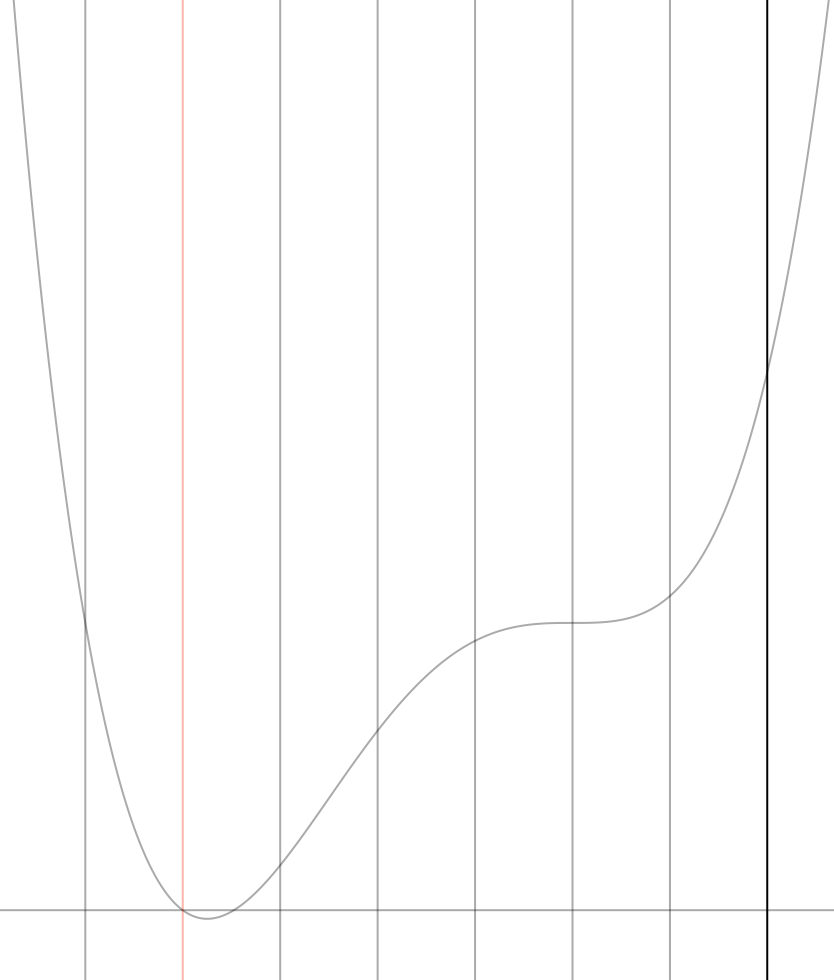

In [5]:
display(Image("figs/grid_search.png", width=350, unconfined=True))

### Fundamental Theorem of Calculus #2

Let $f:[a,b]\rightarrow \mathbb{R}$ be a continuously differentiable function. Then

$$\int\limits_a^b \frac{df}{dt}(t)\;dt=f(b)-f(a).$$

### Convex Sets

A set $K\subset \mathbb{R}^n$ is said to be convex if for every pair of points $x,y \in K$ and for every $\lambda \in [0,1]$, we have 

$$\lambda x + (1-\lambda)y\in K.$$

In other words, a set $K\subset \mathbb{R}^n$ is convex if for every two points in $K$, the line segment connecting them is contained in $K$.

### Convex Function

A function $f:K\rightarrow\mathbb{R}$, defined over a convex set is convex if for all $x,y \in K$ and $\lambda\in[0,1]$, we have

$$f(\lambda x + (1-\lambda)y)\leq \lambda f(x) + (1-\lambda)f(y).$$

We call $f$ strictly convex if the inequality is strict. We also call $f$ concave if $-f$ is convex. Alternatively, we say that a function $f$ is convex iff for all $x,y\in K$ and $\beta\geq 0$ such that $y+\beta(y-x)\in K$, we have

$$f(y+\beta(y-x))\geq f(y)+\beta(f(y)-f(x)).$$

And there's even a third equivalent way of defining a convex function. A function is convex iff its epigraph

$$\text{epi}(f)=\left\{(x,y)\in K\times \mathbb{R}|t\geq f(x)\right\}$$

is a convex set.

### Strongly Convex Function

A function $f$ is called strongly convex on a convex set $Q$ iuf there exists a constant $\mu>0$ such that for all $x,y\in Q$ and $\alpha\in[0,1]$ we have

$$f(\alpha x + (1-\alpha)y)\leq \alpha f(x) + (1-\alpha)f(y)-\frac{1}{2}\mu\alpha (1-\alpha)\lVert x-y\rVert^2.$$

We say that $f\in\mathcal{J}_\mu^0 (Q)$ (i.e. the class of strongly convex functions with constant $\mu$.)

### Closed and Convex Function

A function $f$ is called closed and convex on a convex set $Q\subset\text{dom}(f)$ if its constrained epigraph

$$\text{epi}_Q(f)=\left\{(x,t)\in Q\times\mathbb{R}| t\geq f(x)\right\}$$

is a closed convex set. 

### Bregman Divergence

The Bregman divergence of a function $f:K\rightarrow\mathbb{R}$ at $u,w\in K$ is defined to be:

$$D_f(u,w)\equiv f(w)-\left(f(u)+\langle \nabla f(u),w-u\rangle\right).$$

### Subgradient

A vector $g$ is called a subgradient of the function $f$ at the point $x_0\in\text{dom}(f)$ if for any $y\in\text{dom}(f)$, we have

$$f(y)\geq f(x_0)+\langle g,y-x_0\rangle .$$

The set of all subgradients of $f$ at $x_0$ is the subdifferential of the function $f$ at the point and denoted $\partial f(x_0)$.

### Supporting and Separating Hyperplanes

Let $Q$ be a convex set. We say that the hyperplane

$$\mathcal{H}(g,\gamma)=\left\{x\in\mathbb{R}^n|\langle g,x\rangle =\gamma\right\},\;\;\;g\neq 0,$$

is supporting to $Q$ if any $x\in Q$ satisfies the inequality $\langle g,x\rangle\leq \gamma.$ The hyperplane $\mathcal{H}(g,\gamma)$ that is not a subset of $Q$ separates a point $x_0$ from $Q$ if 

$$\langle g,x\rangle\leq\gamma\leq \langle g,x_0\rangle$$

for all $x\in Q$. If one of the inequalities above is strict, we say the separation is strong.

### Probability Simplex

A probability simplex is defined to be a set of the form

$$\Delta_n\equiv\left\{p\in[0,1]^n: \sum\limits_{i=1}^n p_i=1\right\}.$$

### Kullback-Leibler divergence over $\Delta_n$

For two probability distributions $p,q\in\Delta_n$, their Kullback-Leibler (KL) divergence is defined as

$$D_{KL}(p,q)\equiv -\sum\limits_{i=1}^n p_i\log\frac{q_i}{p_i}.$$

### Homogenous Function

A function $f$ is called positively homogenous of degree $p\geq 0$ if $\text{dom}(f)$ is a cone and 

$$f(\tau x)=\tau^p f(x),\;\;\;\;\forall x\in\text{dom}(f),\;\forall \tau\geq 0.$$

### Karush-Kuhn-Tucker Theorem

Let $\mathcal{K}\subset \mathbb{R}^n$ be a convex subset, $x^*=\arg\min_{x\in\mathcal{K}} f(x)$. Then for all $y\in\mathcal{K}$, we have 

$$\langle\nabla f(x^*), y-x^*\rangle\geq 0.$$

### Supporting and Separating Hyperplanes

Let $Q$ be a convex set. We say that the hyperplane 

$$\mathcal{H}(g,\gamma)=\left\{x\in\mathbb{R}^n:\langle g,x\rangle=\gamma\right\},\;\;\;g\neq 0$$

is supporting to $Q$ if any $x\in Q$ satisfies the inequality $\langle g,x\rangle\leq \gamma$. The hyperplane $\mathcal{H}(g,\gamma)\not\supset Q$ separates a point $x_0$ from $Q$ if 

$$\langle g,x\rangle\leq \gamma\leq \langle g,x_0\rangle$$

for all $x\in Q$. If one of the above inequalities is strict, we say the separation is strong.

Here are some visual examples as these are very important tools in convex analysis.

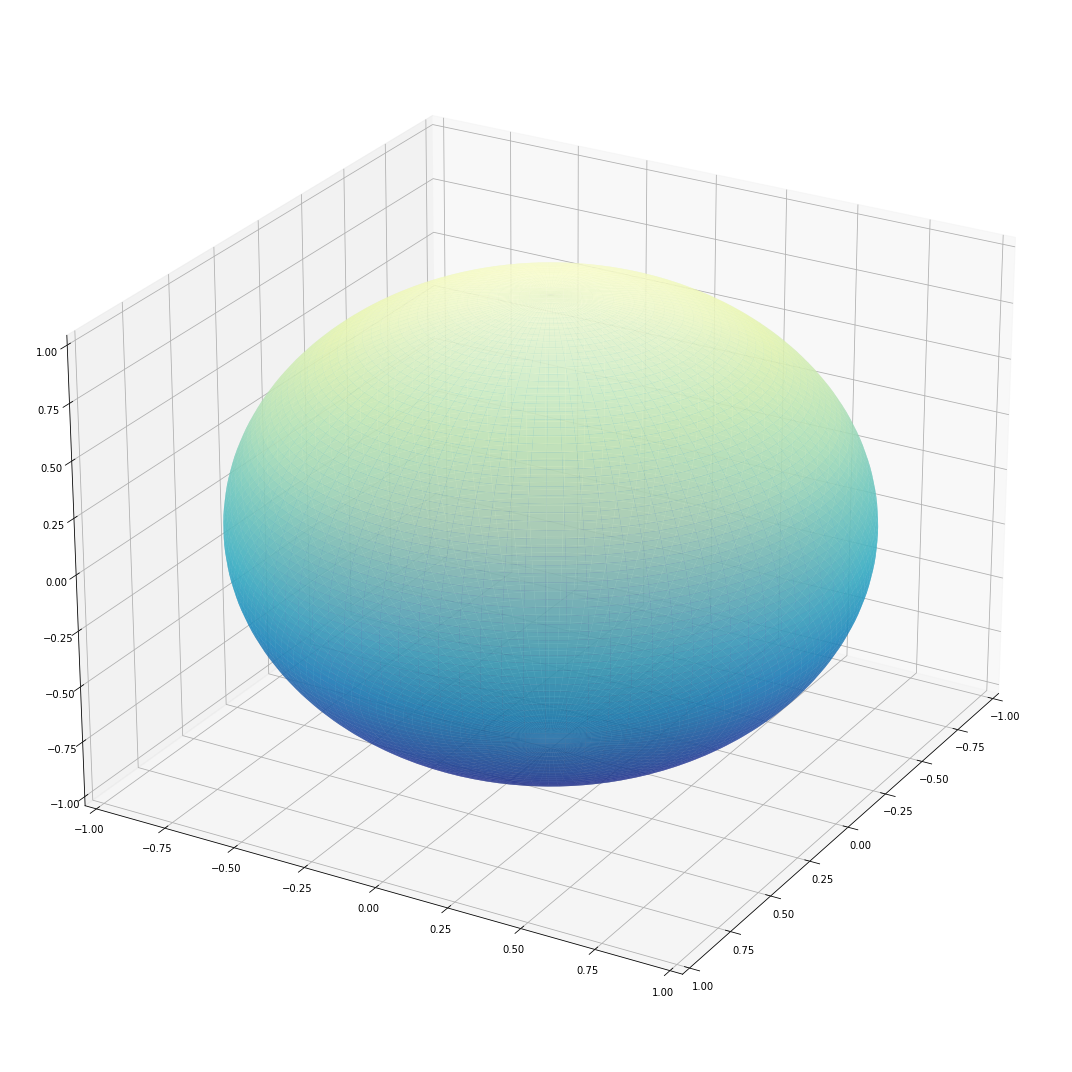

In [17]:
# Create a sphere
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0:pi:100j, 0:2*pi:100j]
x = r*sin(phi)*cos(theta)
y = r*sin(phi)*sin(theta)
z = r*cos(phi)

# Create a 

#Set colours and render
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# plot the sphere
ax.plot_surface(
    x, y, z,  rstride=1, cstride=1, cmap=plt.cm.YlGnBu_r, alpha=0.7, linewidth=0)

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.view_init(25, 30)
plt.tight_layout()
plt.show()


### Unimodal

A real-valued function $f$ is unimodal on an interval if there is a unique value $x^*$ in the interval such that $f(x^*)$ is the minimum of $f$ on the interval, and $f$ is strictly decreasing for $x\leq x^*$ and strictly increasing for $x^*\leq x$. 

### Golden Section Search

If we suppose that $f$ is unimodal on the interval $[a,b]$ and we desire to find the minimum, then there are two key goals for admissible algorithms: 1) minimize the number of function calls and 2) reduce the search interval size each time. 

Consider first the intuitive way of finding the minimum: first find the midpoint of $[a,b]$ which is $m=a+b/2$. Then evaluate $f$ at $m-\frac{\delta}{2}$ and $m+\frac{\delta}{2}$ for small $\delta$. If $f(m-\frac{\delta}{2})<f(m+\frac{\delta}{2})$, we know the minimum cannot lie in $[m+\frac{\delta}{2},b]$ as the function is unimodal over the interval. Thus the next interval we would look at is $[a,m-\frac{\delta}{2}]$ otherwise we'd look at $[m+\frac{\delta}{2},b]$. Notice that we can exclude the interval $(m-\frac{\delta}{2},m+\frac{\delta}{2})$ as $\delta$ is very small. This method halves the search interval at each step but it requires two function calls to find $f(m-\frac{\delta}{2})$ and $f(m+\frac{\delta}{2})$. Let us call this method the midpoint section search. 

Let us see if we can obtain a similar reduction in the interval at each step but only use one function call. If $f(x_1)<f(x_2)$, then our new interval is reduced to $[a,x_2]$ so 

$$x_2 - a = c(b - a)\iff x_2 = (1 - c)a + cb.$$

Otherwise, if $f(x_1)>f(x_2)$, then our interval is $[x_1,b]$ and 

$$b - x_1 = c(b - a)\iff x_1 = ca + (1 - c)b.$$



*Golden Section Search Algorithm* 

* *Input*: a function $f$, a unimodal interval for $f$: $[a,b]$, and an error tolerance $tol$

* $\tau = \frac{\sqrt{5} - 1}{2}$

* $x_1 = a + (1-\tau)(b-a)$

* $f_1 = f(x_1)$

* $x_2 = a + \tau (b-a)$

* $f_2 = f(x_2)$


* *while* $\left((b - a) > tol\right)$ *do*
    * *if* $(f_1 > f_2)$ *then*
        * $a = x_1$

        * $x_1 = x_2$

        * $f_1 = f_2$

        * $x_2 = a + \tau (b-a)$

        * $f_2 = f(x_2)$
   
    * *else*
        * $b = x_2$

        * $x_2 = x_1$

        * $f_2 = f_1$

        * $x_1 = a + (1-\tau)(b-a)$

        * $f_1 = f(x_1)$

    * *end*
    
* *end*


# Algorithm Implementation

This section is designated to implementing the optimization algorithms and benchmarking performance against datasets. 

In [206]:
# Set plotting font sizes and properties
TINY_SIZE = 12
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 20
MARKER_SIZE = 6
LINE_SIZE = 4

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=TINY_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", markersize=MARKER_SIZE)  # marker size
plt.rc("lines", linewidth=LINE_SIZE)  # line width

mpl.rcParams["figure.dpi"] = 180 # sets the image quality

# Height and width per row and column of subplots
FIG_HEIGHT = 18
FIG_WIDTH = 16
fig_fcn = lambda kwargs: plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), **kwargs)
color_list = sns.color_palette("Paired")

In [201]:
# timer class to benchmark running times of algorithms
class Timer: 
    """Record multiple running times"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start timer"""
        self.tik = time.time()

    def stop(self):
        """Stop timer and record the time in a list"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg_time(self):
        """Return average time"""
        return sum(self.times) / len(self.times)

    def sum_time(self):
        """Return sum of time"""
        return sum(self.times)

    def cumsum_time(self):
        """Return accumulated time"""
        return np.array(self.times).cumsum().tolist()

## Subgradient Descent

In [288]:
class SubgradientDescent():
    
    def __init__(self, dim=10, k=5, C=1e-10, max_iter=1000):
        """
        :param: dim - int, size of matrices A_k 
        :param: k - int, number of matrices A_1,\dots, A_k
        :param: C - float, learning rate constant C: eta = C / sqrt{t}
        :param: max_iter - int, max number of iterations allowed
        """
        self.dim = int(dim)
        self.k = int(k)
        self.C = C
        self.max_iter = int(max_iter)
        
        # starting guess for optimum
        self.start = np.ones(dim)
        
        # initialize the set of matrices A_k
        self.A = {}
        for i in range(k):
            A_i = np.zeros(shape=(dim, dim))
            for m in range(dim):
                for n in range(i):
                    A_i[m, n] = np.exp((n + 1) / (m + 1)) * np.cos((m + 1) * (n + 1)) * np.sin((i + 1))
                    A_i[n, m] = A_i[m, n]
                A_i[m, m] = (i / 10) * np.abs(np.sin(i)) + np.sum(np.abs(A_i[m, :m])) + np.sum(np.abs(A_i[m, m+1:]))
            self.A[i] = A_i

        # initialize the vectors b_k
        self.b = {}
        for i in range(k):
            b_i = np.zeros(dim)
            for j in range(dim):
                b_i[j] = np.exp((j + 1) / (i + 1)) * np.sin((i + 1) * (j + 1))
            self.b[i] = b_i 
            
        # keep track of best guess thus far
        self.best_x = self.start
        self.max_val = max([np.dot(self.start, np.dot(self.A[i], self.start)) - np.dot(self.b[i], self.start) for i in range(self.k)])

    def maxquad_obj(self, x):
        results = [np.dot(x, np.dot(self.A[i], x)) - np.dot(self.b[i], x) for i in range(self.k)]
        return max(results)
    
    def subgrad(self, x):
        # grab index of the largest function at point x
        i_max = [np.dot(x, np.dot(self.A[i], x)) - np.dot(self.b[i], x) for i in range(self.k)].index(self.maxquad_obj(x))
        return 2 * np.dot(self.A[i_max], x) - self.b[i_max]
        
    def constant_update(self, x, iter):
        return x - (self.C / np.sqrt(iter)) * self.subgrad(x) / np.sum(self.subgrad(x) ** 2)
    
    def polyak_update(self, x, iter):
        learning_rate = (self.maxquad_obj(x) - self.max_val + (1 / iter)) / np.dot(self.subgrad(x), self.subgrad(x))
        return x - learning_rate * self.subgrad(x) / np.sum(self.subgrad(x) ** 2)
    
    def train(self):
        f_vals = []
        x = self.start
        for epoch in range(1, self.max_iter + 1):
            # take a step
            x = self.polyak_update(x, epoch)
            f_new = self.maxquad_obj(x) 
            if f_new < self.max_val:
                self.best_x = x
                self.max_val = f_new
                f_vals.append(f_new)
            else:
                f_vals.append(self.max_val)
        return f_vals
    
    def graph_log_iter(self):
        y = self.train()
        fig = plt.figure()
        plt.plot(np.log(np.arange(1, self.max_iter + 1)), np.log(y - self.max_val + 1), color='navy')
        plt.xlabel('Log of Iterations')
        plt.ylabel('Log of Sub-Optimality Gap')
        plt.show()
        fig.savefig('polyak_update.jpg', dpi=300)

### Benchmarking Subgradient Descent on MAXQUAD Functions

Here we test the effectiveness of this method on the class of problems formulated as follows:

$$\min\limits_{x\in\mathbb{R}^d}\max\limits_{k\in[d]}\left\{x^TA_kx - \langle b_k, x\rangle\right\}.$$

In this particular case, let me consider $d=10$ and an initial starting point of $x=\left(1,\dots,1\right)^\intercal$.

5258.243638854194


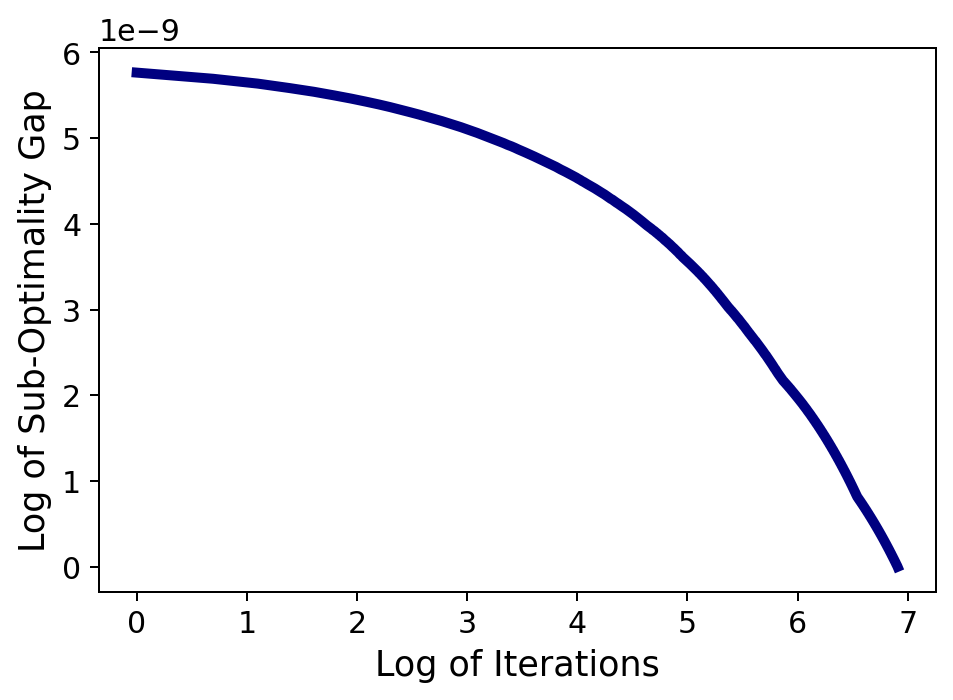

In [287]:
# constant update here
subgrad = SubgradientDescent()
results = subgrad.graph_log_iter()

5258.243638854194


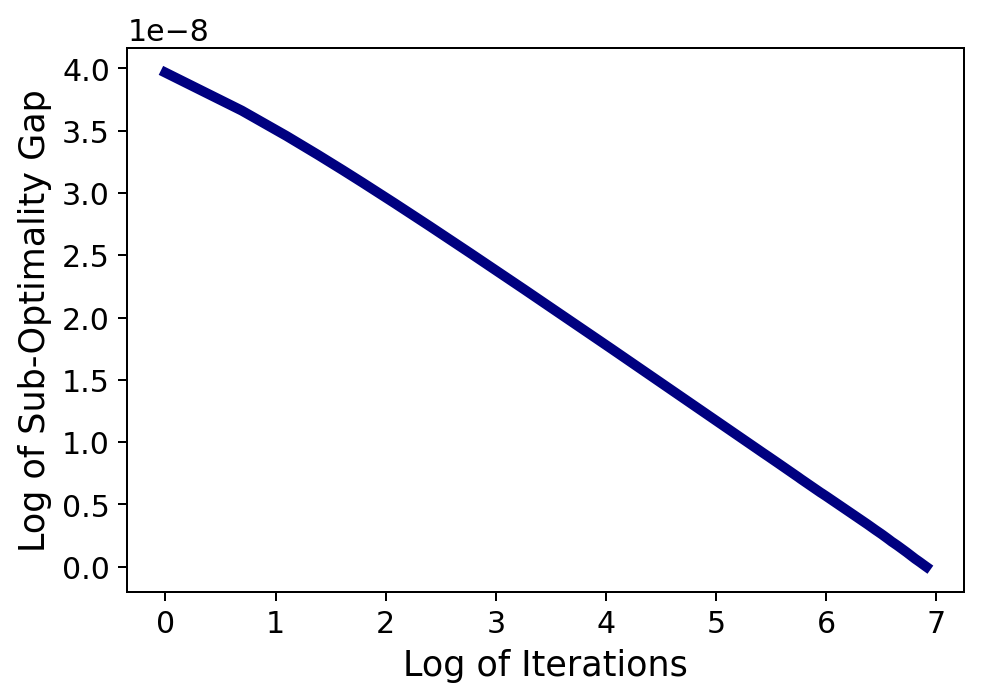

In [289]:
# polyak update
subgrad = SubgradientDescent()
results = subgrad.graph_log_iter()

## Golden Section Search

**Note**: Benchmarking this particular algorithm in relation to other ones is not intelligent in the slightest as this algorithm assumes we already are given a unimodal interval - useful only in theory.

In [3]:
def golden_section_search(f, a, b, tol):
    """
    :param: f - function taking a float as input and float as output 
    :param: a - float, specifying min point on the unimodal interval for f
    :param: b - float, specifying max point on the unimodal interval for f
    :param: tol - float, specifying tolerance for how smallest interval to search
    :return: minimum - float, where f is smallest on the interval
    """
    tau = (np.sqrt(5) - 1) / 2
    x_1 = a + (1 - tau) * (b - a)
    f_1 = f(x_1)
    x_2 = a + tau * (b - a)
    f_2 = f(x_2)
    
    while (b - a) > tol:
        if f_1 > f_2:
            a = x_1
            x_1 = x_2
            f_1 = f_2
            x_2 = a + tau * (b - a)
            f_2 = f(x_2)
        else:
            b = x_2
            x_2 = x_1
            f_2 = f_1
            x_1 = a + (1 - tau) * (b - a)
            f_1 = f(x_1)
            
    return f_1

# Example function
def quadratic_func(x):
    return x ** 2

min_point = -10
max_point = 10
tol = 0.1

# Time how long it takes to find min
timer = Timer()
timer.start()
min_est = golden_section_search(f=quadratic_func, a=min_point, b=max_point, tol=tol)
print(f'Estimated Minimum: {min_est:.7f}')
print(f'Time: {timer.stop():.7f} sec')

Estimated Minimum: 0.0000537
Time: 0.0005488 sec


# Gradient Descent

In [ ]:
def gradient_descent(f, x_0, step_size_rule, epsilon, **kwargs):
    """
    :param: f - function to minimize
    :param: x_0 - initial guess for optimal x_0
    :param: epsilon - error rate
    """
    if step_size_rule == 'constant':
        step_size == kwargs['step_size']
    if step_size_rule == 'square_summable':
        step_size == kwargs['step_size']
    if step_size == '':
        pass
    iteration_count = (L * D ** 2) / epsilon

## Examples

### Convexity 

**Example 1**: A differentiable function $f:K\rightarrow\mathbb{R}$ over a convex set $K$ is convex iff 

$$f(y)\geq f(x) + \langle \nabla f(x),y-x\rangle,\;\;\;\forall x,y\in K.$$

*Proof*: For $\Rightarrow$, we have that as $f$ is convex, 

$$f(\lambda x + (1-\lambda) y)-\lambda f(x)\leq (1-\lambda)f(y)\iff \frac{f(\lambda x + (1-\lambda)y)-\lambda f(x)}{1-\lambda}\leq f(y).$$

Notice that $\lambda f(x)=(\lambda - 1)f(x) + f(x)$, so we have

$$f(x)+\frac{f(\lambda x + (1-\lambda)y)-f(x)}{1-\lambda}\leq f(y).$$

As $1-\lambda\rightarrow 0$, this LHS is exactly the directional derivative of $f(\cdot)$ in the direction $y-x$ leaving us with

$$f(x)+\langle \nabla f(x),y-x\rangle\leq f(y)$$

as desired. For the reverse direction, we have for any $z\in K$ that

$$f(x)\geq f(z) + \langle \nabla f(z), x-z\rangle$$

and 

$$f(y)\geq f(z) + \langle \nabla f(z),y-z\rangle.$$

Multiplying the first by $\lambda$ and the latter by $1-\lambda$ yields

$$\lambda f(x) + (1-\lambda) f(y)\geq f(z) + \lambda \langle \nabla f(z), x-z\rangle + (1-\lambda)\langle \nabla f(z),y-z\rangle$$

$$\iff \lambda f(x) + (1-\lambda) f(y)\geq f(z) + \langle \nabla f(z), \lambda x + (1-\lambda)y - z\rangle.$$

Taking $z=\lambda x + (1-\lambda)y$ yields

$$\lambda f(x) + (1-\lambda)f(y)\geq f(z)=f\left(\lambda x + (1-\lambda)y\right)$$

which finishes the proof of both directions and thus equivalence of the statements under the condition that $f(\cdot)$ is differentiable over the convex set $K$.

**Example 2**: If $f:K\rightarrow \mathbb{R}$ is convex over $K$, then $f$ is continuous over $K$.

*Proof*: We see that if $f$ is convex that ....

**Example 3**: A function $f$ is convex iff for all $x,y\in\text{dom}(f)$ and $\beta>0$ such that $y+\beta(y-x)\in\text{dom}(f)$, we have

$$f(y+\beta(y-x))\geq f(y) + \beta (f(y) - f(x)).$$

*Proof*: Intuitively, this mirrors exactly what the usual definition of convexity says (a function evalulated at interpolation of two points is larger than the sum of the interpolations of the functions). To see this is the same, just fix $x,y\in\text{dom}(f)$. Then we are just stretching a band above the curve from $y$ to $\beta (y-x)$. As examining if this band is above the curve for fixed $x$ and $y$ is not enough (think of $f(x)=x^3$ where I let $x=0$ and $y>0$), I must check this condition for all $x,y\in\text{dom}(f)$. I won't include a rigorous explanation as the visual/concept is more important.

**Example 4**: A function $f$ is convex iff its epigraph

$$\text{epi}(f)=\left\{(x,t)\in\text{dom}(f)\times\mathbb{R}|t\geq f(x)\right\}$$

is convex. 

*Proof*: Trivial - excluded.

**Example 5**: If a function $f$ is convex, then all level sets

$$\mathcal{L}_f(\beta)=\left\{x\in\text{dom}(f):f(x)\leq \beta\right\}$$

are convex or empty.

*Proof*: The image of this is more important than the algebra. When I think of this, I like to visualize a simple paraboloid where it affirms the idea that if I take a level set of this, it will still resemble a paraboloid with a smaller height - thus still retaining the property of convexity.

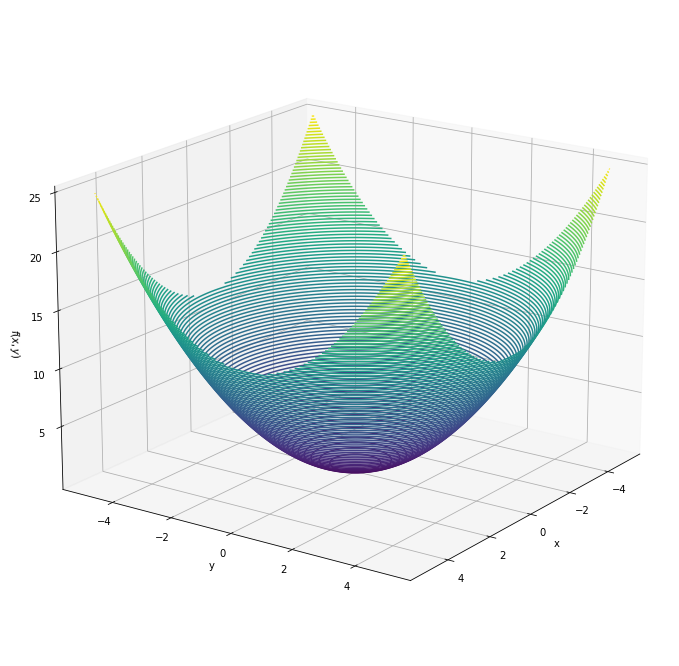

In [26]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection='3d')

def paraboloid(x, y):
    return (1 / 2) * (x ** 2 + y ** 2)

x, y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
ax.contour3D(x, y, paraboloid(x,y), 100)
ax.view_init(18, 35)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$f(x,y)$')
plt.show()



### Subdifferentiability

**Example 1**: If $f(x)=\text{ReLU}(x)\equiv \max\{x,0\}$, then at $x=0$, $\partial f(0)=[0,1]$ as 

$$\max\{z,0\}\geq z\geq \langle g^t,z\rangle$$

for all $z\in K$. If $g^t\in[-1,0]$, then we'd run into the issue for $z<-\frac{-1}{g^t}$.

**Example 2**: If $f(x)=\text{ReLU}(x)\equiv \max\{x,0\}^2$, then at $x=0$, $\partial f(0)=0$. 

**Example 3**: 

### Mean Value Theorem (MVT)

**Example 1**: For a differentiable $f:K\rightarrow\mathbb{R}$, we have for all $x,y\in K$ that 

$$f(y)=f(x)+\int\limits_0^1 \langle\nabla f(x+\tau(y-x)), y-x\rangle\;d\tau.$$

**Example 2**: For a twice-differentiable $f:K\rightarrow\mathbb{R}$, we have for all $x,y\in K$ that 

$$\nabla f(y) = \nabla f(x) + \int\limits_0^1 \nabla^2 f(x+\tau(y-x))(y-x)\;d\tau.$$

**Example 3**: If $f$ is continuously differentiable with Lipschitz gradient with constant $L$, then for all $x,y\in\mathbb{R}^n$, we have

$$\left|f(y)-f(x)-\langle \nabla f(x),y-x\rangle\right|\leq \frac{L}{2}\lVert y-x\rVert^2.$$

*Proof*: By MVT and adding zero, we have 

$$f(y)=f(x)+\int\limits_0^1 \langle\nabla f(x+\tau(y-x)),y-x\rangle\;d\tau =f(x)+\langle \nabla f(x),y-x\rangle + \int\limits_0^1 \langle \nabla f(x+\tau(y-x)),y-x\rangle - \langle \nabla f(x),y-x\rangle\;d\tau$$

$$\iff \left|f(y)-f(x)-\langle \nabla f(x),y-x\rangle\right|=\left|\int\limits_0^1 \langle \nabla f(x+\tau(y-x))-\nabla f(x),y-x\rangle\;d\tau\right|.$$

By Cauchy Schwartz and the definition of Lipschitz continuity, this implies 

$$\left|f(y)-f(x)-\langle \nabla f(x),y-x\rangle\right|\leq \int\limits_0^1 L\lVert \tau (y-x)\rVert\cdot \lVert y-x\rVert\;d\tau = \frac{L}{2}\lVert y-x\rVert^2.$$

### Lipschitz Continuity

**Example 1**: For the function $f(x)=\alpha x + b$, we have for all $x_1,x_2\in\mathbb{R}$ that

$$|f(x_1)-f(x_2)|=|\alpha(x_1-x_2)|\leq |\alpha|\cdot |x_1-x_2|$$

implying that it is indeed Lipschitz.

**Example 2**: For any Lipschitz continuous function, uniform grid search yields that for a local extrema $x^*$ and a guess $\bar{x}$ on a uniform box, we have

$$|f(\bar{x})-f(x^*)|\leq \frac{L}{p}.$$

*Proof*: Why well notice that as $x_i\in[0,1]$ and $f(\cdot)$ is Lipschitz, we have

$$|f(\bar{x}) - f(x^*)|\leq L\lVert \bar{x} - x^*\rVert_\infty=L\max\limits_{k\in[n]} \left|\frac{2i_k-1}{2p}-x_k\right|$$

$$=L\max\limits_{k\in[n]} \left|\frac{i_k-px_k}{p}-\frac{1}{2p}\right|\leq L\left|-\frac{1}{2p}\right|=\frac{L}{2p}.$$


### Unimodal Functions

Clearly $y=x^2$ is unimodal over all of $\mathbb{R}$ and we can see that below. A function is unimodal again if there is a unique local minimum for some interval $[a,b]$ - uniqueness of the local minimum can be found by checking if the derivative of the function is zero or not. $y=20$ has derivative zero and we see the minimum is not unique.

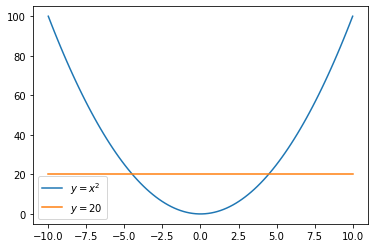

In [5]:
x = np.linspace(-10, 10, 100)
y1 = x ** 2
fig = plt.figure()
ax = plt.axes()
ax.plot(x, y1, label = "$y=x^2$")
ax.plot(x, np.repeat(20, 100), label = "$y=20$")
ax.legend()

### Golden Section Search Example

Consider the above function $y = x^2$ on the interval $[-10,10]$ where it is unimodal. We can look at the iterations of the algorithm below. This is a very simple function and as evidence, this converges to the minimum in less than 10 iterations quite quickly. 

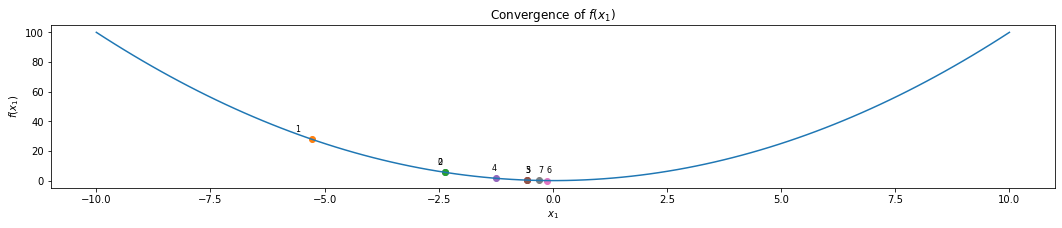

In [32]:
def quadratic_func(x):
    return x ** 2

# intializing params
a = -10
b = 10
tol = 0.1

# generate the points for plotting
start_points = []
end_points = []
start_values = []
end_values = []

tau = (np.sqrt(5) - 1) / 2
x_1 = a + (1 - tau) * (b - a)
start_points.append(x_1)
f_1 = quadratic_func(x_1)
start_values.append(f_1)
x_2 = a + tau * (b - a)
end_points.append(x_2)
f_2 = quadratic_func(x_2)
end_values.append(f_2)

while (b - a) > tol:
    if f_1 > f_2:
        a = x_1
        x_1 = x_2
        start_points.append(x_1)
        f_1 = f_2
        start_values.append(f_1)
        x_2 = a + tau * (b - a)
        end_points.append(x_2)
        f_2 = quadratic_func(x_2)
        end_values.append(f_2)
    else:
        b = x_2
        x_2 = x_1
        end_points.append(x_2)
        f_2 = f_1
        end_values.append(f_2)
        x_1 = a + (1 - tau) * (b - a)
        start_points.append(x_1)
        f_1 = quadratic_func(x_1)
        start_values.append(f_1)
                
fig, ax = plt.subplots(figsize=(18, 3))
x = np.linspace(-10, 10, 100)
y1 = x ** 2
ax.plot(x, y1, label = "$y=x^2$")
for i in range(8):
    ax.scatter(start_points[i], start_values[i])
    ax.text(start_points[i] * (1.07), start_values[i] + 5 , i, fontsize=8)
    
plt.xlabel("$x_1$")
plt.ylabel("$f(x_1)$")
plt.title("Convergence of $f(x_1)$")
plt.show()

## Theory Problems

## Problems in Vishnoi's book

### Preliminaries

**2.1**: For each of the following functions, compute the gradient and the Hessian, and write the second-order Taylor approximation

**(a)** $f(x)=\sum\limits_{i=1}^m (a_i^T x - b_i)^2$ for $x\in\mathbb{Q}^n$, where $a_1,\dots,a_m\in\mathbb{Q}^n$ and $b_1,\dots,b_m\in\mathbb{Q}$.

**(b)** $f(x)=\log\left(\sum\limits_{j=1}^m e^{\langle x,v_j\rangle}\right)$, where $v_1,\dots,v_m\in\mathbb{Q}^n$

**(c)** $f(X)=\text{Tr}(AX)$, where $A$ is a symmetric $n\times n$ matrix and $X$ runs over symmetric matrices.

**(d)** $f(X)=-\log \det X$, where $X$ runs over positive definite matrices.

- For (a), we have 

$$\nabla f(x) = \sum\limits_{i=1}^m 2(a_i^Tx - b_i)a_i^T$$

and 

$$H(f(x)) = J(\nabla f(x)) = \sum\limits_{i=1}^m 2a_ia_i^T.$$

Thus our second order Taylor approximation is given by 

$$f(x)=f(a) + \langle \nabla f(a),x-a\rangle + \frac{1}{2}\langle \nabla^2 f(a)(x-a),x-a\rangle + o((x-a)^3)$$

$$=\sum\limits_{i=1}^m (a_i^T a - b_i)^2 + \langle \sum\limits_{i=1}^m 2(a_i^Ta - b_i)a_i^T, x-a\rangle + \frac{1}{2}\langle \sum\limits_{i=1}^m 2a_ia_i^T(x-a),x-a\rangle.$$

For (b), we have 

$$\nabla f(x)= \frac{\sum\limits_{i=1}^m e^{\langle x,v_j\rangle}v_j^T}{\sum\limits_{i=1}^m e^{\langle x,v_j\rangle}}$$

and 

$$H(f(x))=\frac{\left(\sum\limits_{i=1}^m e^{\langle x,v_j\rangle} v_jv_j^T\right)\left(\sum\limits_{i=1}^m e^{\langle x,v_j\rangle}\right) - \left(\sum\limits_{i=1}^m e^{\langle x,v_j\rangle} v_j^T\right)^T\left(\sum\limits_{i=1}^m e^{\langle x,v_j\rangle}v_j^T\right)}{\left(\sum\limits_{i=1}^m e^{\langle x,v_j\rangle}\right)^2}$$

so we can plug in again to get the second-order Taylor approximation. (c) and (d) are of similar flavor, so I will just solve (c). This problem differs from the prior in that $f:\mathbb{R}^{n\times n}\rightarrow \mathbb{R}$. Notice that

$$\text{Tr}(AX)=\text{Tr}\left(\sum\limits_{i=1}^n \lambda_i v_iv_i^T X\right),$$

where $A=\sum\limits_{i=1}^n \lambda_i v_iv_i^T$ so 

$$\nabla f(X)=\frac{\partial \text{Tr}\left(\sum\limits_{i=1}^n \lambda_i v_iv_i^T X\right)}{\partial X}=\frac{\partial \left(\sum\limits_{i=1}^n \lambda_i \text{Tr}(v_iv_i^TX)\right)}{\partial X}=\frac{\partial\left(\sum\limits_{i=1}^n \lambda_i v_i^TXv_i\right)}{\partial X}=\sum\limits_{i=1}^n \lambda_i v_iv_i^T$$

and thus 

$$H(f(X))=0,$$

so collecting these terms yields the Taylor expansion is given by 

$$f(X)=\text{Tr}(AY)+\langle \sum\limits_{i=1}^n \lambda_i v_iv_i^T,\lVert Y-X\rVert\rangle$$

where $\lVert\cdot\rVert$ here denotes a matrix norm of your choice.

**2.2** Prove Lemma 2.6: Let $f:\mathbb{R}^n\rightarrow\mathbb{R}$ be a continuously differentiable function. For $x,y\in\mathbb{R}$, let $g:[0,1]\rightarrow\mathbb{R}$ be defined as 

$$g(t)\equiv f(x+t(y-x)).$$

Then the following are true:

a) $\frac{dg}{dt}=\langle \nabla f(x+t(y-x)),y-x\rangle$

b) $f(y)=f(x)+\int\limits_0^1 \frac{dg}{dt}\;dt$.

- answer mark

### Convexity (ch. 3)

**3.1** Is the intersection of two convex sets convex? Is the union of two convex sets convex?

- If $A$ and $B$ are two convex sets, then if $x,y\in A\cap B$, then $x,y\in A$ and $x,y\in B$, which means that for $\lambda\in [0,1]$, we have $\lambda x +(1-\lambda)y\in A$ and $\lambda x + (1-\lambda y\in B)$. For the latter question, consider two disjoint circles in $\mathbb{R}^2$ for a visual counterexample. 

**3.2** Prove the following are convex: (a) Polyhedra: $K=\{x\in\mathbb{R}^n: \langle a_i,x\rangle\leq b_i\}$, (b) Ellipsoids: $K=\{x\in\mathbb{R}^n: x^TAx\leq 1\}$ for positive definite $A$, and (c) Unit balls in $\ell_p$-norms for $p\geq 1$: $K=\{x\in\mathbb{R}^n: \lvert x-a\rVert_p\leq 1\}$.

- All of these can be trivially shown to be convex. For the polyhedra, we have if $x,y\in K$, then for $\lambda\in[0,1]$

$$\langle a_i,\lambda x + (1-\lambda)y\rangle=\lambda\langle a_i,x\rangle + (1-\lambda) \langle a_i,y\rangle\leq \lambda b_i + (1-\lambda)b_i=b_i.$$

For ellipsoids, we have 

$$(\lambda x+(1-\lambda)y)^TA(\lambda x+(1-\lambda)y)=\lambda^2 x^TAx + \lambda (1-\lambda)(x^TAy+y^TAx) + (1-\lambda)^2y^TAy$$

$$\leq \lambda^2 + \lambda (1-\lambda)(x^TAy+y^TAx) + (1-\lambda)^2\leq (\lambda+(1-\lambda))^2=1.$$

Finally, for unit balls, it more or less follows from ellipsoids where $A$ is diagonal, so that is also indeed convex.

**3.3** Prove that if $f:\mathbb{R}^n\rightarrow \mathbb{R}$ is a convex function, then all its sublevel sets are convex.

- Sublevel sets are of the form: $\mathcal{L}_f(\alpha)=\{x\in\mathbb{R}^n: f(x)\leq \alpha\}$. 

**3.4** Prove that a function $f:K\rightarrow\mathbb{R}$, where $K\subset \mathbb{R}^n$ is convex, is convex iff $\text{epi}(f)$ is convex.

- asdf

**3.5** For two sets $S,T\subset\mathbb{R}^n$, define their Mikowski sum to be 

$$S+T\equiv \{x+y:x\in S,y\in T\}.$$

Prove that if $S$ and $T$ are convex, then so is their Minkowski sum.

- asdf

**3.6** Prove that a polyhedron $K\subset\mathbb{R}^n$ is bounded, i.e., $K$ is contained in an $\ell_2$-ball of radius $r<\infty$, then it can be written as a convex hull of finitely many points, i.e. $K$ is also a polytope.

- asdf

**3.7** Prove that the set of $n\times n$ real PSD matrices is convex.

- asdf

**3.8** Prove that if $f:\mathbb{R}^n\rightarrow\mathbb{R}$ is convex, $A\in\mathbb{R}^{n\times m}$ and $b\in\mathbb{R}^n$ then $g(y)\equiv f(Ay+b)$ is also convex.

- asdf

**3.9**  


**3.10**


**3.11**


**3.12**


**3.13**


**3.14**


### Gradient Descent (ch. 6)

**6.1** Let $f:\mathbb{R}^n\rightarrow\mathbb{R}$ be a differentiable function. Prove that if $\lVert \nabla f(x)\rVert\leq G$ for all $x\in\mathbb{R}^n$ and some $G>0$, then $f$ is $G$-Lipschitz continuous.

- As $f$ is differentiable, for all $x$, we can invoke the MVT and Cauchy-Schwartz: for all $x,y\in\mathbb{R}^n$ there is some $\lambda\in(0,1)$ such that

$$|f(x)-f(y)|=\left| \nabla f\left(\lambda x + (1-\lambda)y\right)(x-y)\right|\leq \left| \nabla f\left(\lambda x + (1-\lambda)y\right)\right|\cdot |x-y|\leq G|x-y|.$$

**6.2** Suppose that a differentiable function $f:\mathbb{R}^n\rightarrow\mathbb{R}$ has the property that for all $x,y\in\mathbb{R}^n$,

$$f(y)\leq f(x) + \langle y-x,\nabla f(x)\rangle + \frac{L}{2}\lVert x-y\rVert^2.$$

Prove that if $f$ is twice-differentiable and has a continuous Hessian, then the above is equivalent to $\nabla^2 f(x)\preccurlyeq LI$. Further, prove that if $f$ is also convex, then the above is equivalent to the condition that the gradient of $f$ is $L$-Lipschitz continuous.

- To prove equivalence in the first statement, let us show $\Leftarrow$ first. If $\lVert \nabla^2f(x)\rVert\leq \lVert LI\rVert$, then by Taylor expansion and Cauchy-Schwartz, we have

$$f(y)\leq f(x)+\langle y-x,\nabla f(x)\rangle + \frac{1}{2}\langle \nabla^2f(x)(y-x),y-x\rangle\leq f(x) + \langle y-x,\nabla f(x)\rangle + \frac{1}{2}\lVert\nabla^2f(x)\rVert\lVert y-x\rVert$$

$$\leq f(x) + \langle y-x,\nabla f(x)\rangle + \frac{L}{2}\lVert y-x\rVert.$$

For the reverse direction, I have no clue - usually we assume that $f$ is convex: asked here https://math.stackexchange.com/questions/4370965/gradient-descent-norm-of-hessian-bound.

As for the second statement where we assume $f$ is convex, then the gradient being $L$-Lipschitz is equivalent to the above inequality, the reverse direction $(\Leftarrow)$ is interesting. Notice that by FTC (Fundamental Theorem of Calculus) we know that for $t\in\mathbb{R}^n$ and $\delta >0$,

$$\int\limits_0^\delta \nabla^2 f(x+tz)\;dz=\nabla f(x+t\delta)-\nabla f(x).$$

Thus, letting $\delta\rightarrow 0$, we have

$$\lim\limits_{\delta\rightarrow 0} \frac{\lVert \int\limits_0^\delta \nabla^2 f(x+tz)\;dz\rVert}{\lVert t\delta\rVert}=\lim\limits_{\delta\rightarrow 0} \frac{\lVert \nabla f(x+t\delta)-\nabla f(x)\rVert}{\delta \lVert t\rVert}\leq \frac{L\lVert x+t\delta - x\rVert}{\delta\lVert t\rVert}=L,$$

and so $\lVert \nabla^2 f(x)\rVert\leq L$ which is equivalent to the condition above as we proved in the first statement. To prove $(\Rightarrow)$, we 

**6.8** Frank-Wolfe method. Consider the following algorithm for minimizing a convex function $f:K\rightarrow\mathbb{R}$ over a convex domain $K\subset \mathbb{R}^n$.

- Initialize $x_0\in K$,

- For each iteration $t=0,\dots,T$:

    - Define $z_t\equiv \arg\min_{x\in K} \left\{f(x_t)+\langle \nabla f(x_t),x-x_t\rangle\right\}$
    - Let $x_{t+1}\equiv (1-\gamma_t)x_t + \gamma_t z_t$, for some $\gamma_t\in[0,1]$
    
- Output $x_T$.

**(a)** Prove that if the gradient of $f$ is $L$-Lipschitz continuous, $\max_{x,y} \lVert x-y\rVert\leq D$, and $\gamma_t$ is taken to be $\mathcal{O}(t^{-1})$, then 

$$f(x_T)-f(x^*)\leq \mathcal{O}\left(\frac{LD^2}{T}\right),$$

where $x^*$ is any minimizer of $\min_{x\in K} f(x)$.

**(b)** Show tht one iteration of this algorithm can be implemented efficiently when given a first-order oracle access to $f$ and the set $K$ is a ball of radius one with (1) respect to the $\ell_\infty$ norm, the $\ell_1$ norm, and the $\ell_2$ norm.

- We have for $(a)$, that

$$R(x^{t+1})-R(x^t)=f(x^{t+1})-f(x^t)=f\left((1-\gamma^t)x^t + \gamma^t z^t\right)-f(x^t)$$

$$\leq \gamma^t \left[f(z^t)-f(x^t)\right].$$

From here, we see that along the lines of GD where we choose a step size of $\frac{1}{L}$ - $\gamma^t=\frac{1}{L}$

**6.9** Recall that for a nonempty subset $K\subset\mathbb{R}^n$, we can define the distance function $\text{dist}(x,K)=\inf\limits_{y\in K} \lVert x-y\rVert$ and $\text{proj}_K(x)=\arg\inf_{y\in K} \lVert x-y\rVert$. 

**(a)** Prove that $\text{proj}_K$ is well-defined when $K$ is a closed and convex set, i.e., show that the minimum is attained at a unique point.

**(b)** Prove that for all $x,y\in\mathbb{R}^n$, 

$$\lVert \text{proj}_K(x)-\text{proj}_K(y)\rVert\leq \lVert x-y\rVert.$$

**(c)** Prove that for any set $K\subset\mathbb{R}^n$, the function $x\mapsto \text{dist}^2(x,K)$ is convex.

**(d)** Prove correctness of the explicity formula in equation 6.13 for the projection operator $\text{proj}_K$ when $K=B_{m,\infty}=\{x\in\mathbb{R}^m : \lVert x\rVert_\infty\leq 1\}$.

**(e)** Prove that the function $f(x)\equiv \text{dist}^2(x,K)$ has a Lipschitz continuous gradient with Lipschitz constant equal to 2.

- For part (a), assume the contrary that there are two points that yield a minimum distance from $x$ in $K$ say $y,z$. Then by convexity of $K$, we know that $\lambda x + (1-\lambda)y$ is contained in $K$. Thus if we consider the bisection of $y$ and $z$, say $h\in K$, we realize by Pythagorean theorem that $\lVert x-h\rVert<\lVert x-y\rVert=\lVert x-z\rVert$. 

### Mirror Descent and the Multiplicative Weights Update (ch. 7)

**7.1** Prove that if $f:\mathbb{R}^n\rightarrow \mathbb{R}$ is a convex function that is G-Lipschitz continuous, then $\lVert \nabla f(x)\rVert \leq G$ for all $x\in\mathbb{R}^n$. Extend this result to the case when $f: K\rightarrow\mathbb{R}$ for some convex set $K$.

- 


**7.5** Prove the following properties of KL-divergence: (a) $D_{KL}$ is not symmetric: $D_{KL}(p,q)\neq D_{KL}(q,p)$ for all $p,q\in\Delta_n$ and (b) $D_{KL}$ is indeed a Bregman divergence of a convex function on $\Delta_n$ and $D_{KL}(p,q)\geq 0$.

- For (a), on the two-simplex, consider $p=\{1,0\}$ and $q=\{\frac{1}{2},\frac{1}{2}\}$. Then we have

$$D_{KL}(p,q)=-\left(\log\frac{1}{2}+0\times\log \frac{1/2}{0}\right)=-\log \frac{1}{2}$$

whereas 

$$D_{KL}(q,p)=-\left(\frac{1}{2}\log 2+\frac{1}{2}\log \frac{0}{1/2}\right)=\infty.$$

In the latter part (b), we have that


## Coding Problems

asdf

# Sources

- http://web.mit.edu/dimitrib/www/Convex_Theory_Entire_Book.pdf
    - honestly the most intuitive and graphic way of explaining convexity for starters - start here :)
    
    
- "Scientific Computing: An Introductory Survey" by Michael Heath.
    - Cool book - used at stanford for graduate ml course
    
    
- "Lectures on Convex Optimization" by Yurii Nesterov
    - Book here for 227c (grad convex optimization)
    
    
- "Algorithms for Convex Optimization" by Vishnoi
    - Book here for 227c
    
- https://math.mit.edu/~goemans/PAPERS/book-ch4.pdf
    - on graphs
    
- Nemirov's Courase: https://www2.isye.gatech.edu/~nemirovs/LMCOLN2022WithSol.pdf
    - insanely good w/ applications but lacking in formalism - like the opposite of Nesterov's book

Websites:
- Tutorial on basics of multivariable calculus: https://tutorial.math.lamar.edu/classes/calciii/directionalderiv.aspx

- Another source on multivariable calculus: http://cs231n.stanford.edu/vecDerivs.pdf

- Yet another source on Taylor's theorem: https://people.math.harvard.edu/~knill/teaching/math22a2018/handouts/lecture17.pdf

Blogs:
- http://www.offconvex.org

Subgradient Notes and Courses:

- https://stanford.edu/class/ee364b/lectures/subgradients_notes.pdf

- https://web.stanford.edu/class/ee364b/

- http://www.seas.ucla.edu/~vandenbe/236C/lectures/subgradients.pdf

- https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-253-convex-analysis-and-optimization-spring-2012/assignments/

- https://sachdevasushant.github.io/courses/15s-cpsc665/notes/linsys.pdf

SGD:

- https://www.cs.cornell.edu/courses/cs4787/2019sp/notes/lecture5.pdf

